In [5]:
# Set main root
from setup import setup_project_root
setup_project_root()

In [6]:
from langaugedetection.data.com_voice_dir import open_files, person_to_group

en_df = open_files('en', 10_000)
it_df = open_files('it', 10_000)

en_people = person_to_group(en_df)
it_people = person_to_group(it_df)

print(f'Unique English speakers: {len(en_people)}')
print(f'Unique Italian speakers: {len(it_people)}')

Loading en from: /Users/jonathan/Desktop/UROP/Coding/language-detection/data/en/validated.tsv
Loading it from: /Users/jonathan/Desktop/UROP/Coding/language-detection/data/it/validated.tsv
Unique English speakers: 926
Unique Italian speakers: 2012


In [33]:
import importlib
import langaugedetection.data.audio_length as audio_length

from langaugedetection.data.audio_length import valid_paths, random_audio

importlib.reload(audio_length)

import random

choices = 2

en_people_to_paths = {people : valid_paths(df, 5, 1, 'en') for people, df in en_people.items()}
it_people_to_paths = {people : valid_paths(df, 5, 1, 'it') for people, df in it_people.items()}

en_audio = []
for _, files in en_people_to_paths.items():
    en_audio.extend(random.sample(files, min(len(files), choices)))

it_audio = []
for _, files in it_people_to_paths.items():
    it_audio.extend(random.sample(files, min(len(files), choices)))

print(f'English Data Files: {len(en_audio)}')
print(f'Italian Data Files: {len(it_audio)}')

English Data Files: 595
Italian Data Files: 899


In [13]:
from langaugedetection.data.spectrogram import parse

en_spect = parse(en_audio)
it_spect = parse(it_audio)

In [14]:
from langaugedetection.data.tensor_construct import build_tensor

en_tensor = build_tensor(en_spect)
it_tensor = build_tensor(it_spect)

print(f'English tensor shape is: {en_tensor.shape}')
print(f'Italian tensor shape is: {it_tensor.shape}')

English tensor shape is: torch.Size([595, 1, 1025, 216])
Italian tensor shape is: torch.Size([899, 1, 1025, 216])


In [15]:
from sklearn.preprocessing import LabelEncoder
import torch

English_entries = en_tensor.shape[0]
Italian_entries = it_tensor.shape[0]

encoder = LabelEncoder()

encoder.fit(['English', 'Italian'])

en_encoder_label = encoder.transform(English_entries * ['English'])
it_encoder_label = encoder.transform(Italian_entries * ['Italian'])

en_y = torch.tensor(en_encoder_label, dtype = torch.float32)
it_y = torch.tensor(it_encoder_label, dtype = torch.float32)

In [16]:
from torch.utils.data import TensorDataset, ConcatDataset
from langaugedetection.data.tensor_construct import split_dataset

train_en, test_en = split_dataset(TensorDataset(en_tensor, en_y), .8)
train_it, test_it = split_dataset(TensorDataset(it_tensor, it_y), .8)

train = ConcatDataset([train_en, train_it])
test = ConcatDataset([test_en, test_it])

print(f'Training values: {len(train)}')
print(f'Testing values: {len(test)}')

Training values: 1195
Testing values: 299


In [17]:
from torch.utils.data import DataLoader

loader = DataLoader(train, batch_size=64, shuffle = True)

In [18]:
import torch.nn as nn

class LanguageDetector(nn.Module):
    def __init__(self):
        super().__init__()

        # 2 Convolution Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Neuron Layers
        # Now apply linear layer --> Dimensions of input are 
        # Con1 
        # (1025, 216) --> (512, 108)
        # Con2
        # (512, 108) --> (256, 54)
        # Now we have 32 of these with respective filters applied
        self.fc1 = nn.Linear(32 * 256 * 54, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 1)

        # Relu, Pool Function
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)


    def forward(self, x):

        # 2D Convolution Apllication
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten Dimensions
        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # Sigmoid
        x = self.fc3(x)

        return x

model = LanguageDetector()

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [20]:
# Train
model.train()
num_epochs = 1 # Should be around 25
total_loss = []

for i in range(num_epochs):

    epoch_loss = 0

    for x_batch, y_batch in loader:

        # Evaluate
        outputs = model(x_batch).squeeze(1)
        loss = criterion(outputs, y_batch.float())

        # Update Model
        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss

    total_loss.append(epoch_loss / len(loader))

    print(f'Epoch : [{i+1} /{num_epochs}], loss {total_loss[-1]}')

Epoch : [1 /1], loss 0.8490292429924011


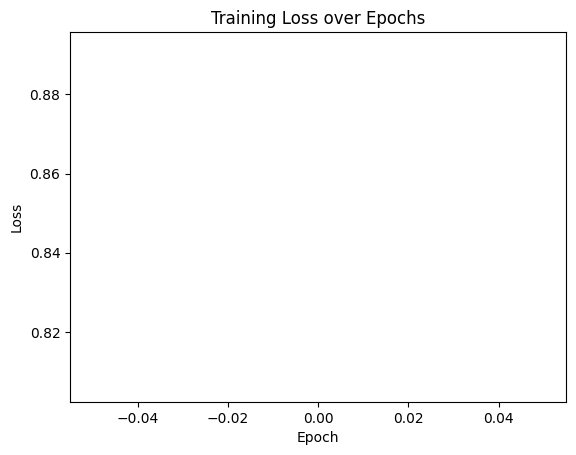

In [21]:
import matplotlib.pyplot as plt

plt.plot([val.item() for val in total_loss])
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
model.eval()

# Note, defined earlier that testing is dloader with batch size, size of
# testing dataset
testing = DataLoader(test, batch_size=len(test), shuffle = False)


with torch.no_grad():
    for x_test, y_test in testing:
        predictions = model(x_test)
        predicted_classes = (predictions >= .5).float()
        y_correct = y_test

y_true = y_correct.numpy()
y_pred = predicted_classes.numpy()

print(f'Lenght of actual: {len(y_true)}')
print(f'Length of predicted: {len(y_pred)}')

Lenght of actual: 299
Length of predicted: 299


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.6020066889632107

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       119
         1.0       0.60      1.00      0.75       180

    accuracy                           0.60       299
   macro avg       0.30      0.50      0.38       299
weighted avg       0.36      0.60      0.45       299


Confusion Matrix:
 [[  0 119]
 [  0 180]]


/Users/jonathan/Desktop/UROP/Coding/language-detection/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathan/Desktop/UROP/Coding/language-detection/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jonathan/Desktop/UROP/Coding/language-detection/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

In [26]:
torch.save(model.state_dict(), f'models/epochs_{num_epochs}__data_{len(train)}__accuracy_{accuracy_score(y_true, y_pred)}.pth')